# CASADI Opti stack rewrite 
Fix all the god damn bugs

Assume we have a discrete-time model:
$$x_{t+1} = f(x_t, u_t)$$
Denote a whole MPC trajectory, with states $x_0,x_1,\dots,x_N$ and controls $u_1,\dots,u_N$ as $\mathbf{x}$ and $\mathbf{u}$.

We have positional constraints:
$$Ax \leq b$$

We have some interval constraints:
$$x_{min} \leq x_t \leq x_{max},\ i=0,\dots,N$$
$$u_{min} \leq u_t \leq u_{max},\ i=1,\dots,N$$

We have multiobjective weighted cost function which is probably quadratic.
    $$J(\mathbf{x}, \mathbf{u})$$

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


Assume zero-order-hold on the controls. and $t$, $t+1$ are separated by time $\Delta t$. A very easy discretization is $x_{t+1} = x_t + \dot x_t \Delta t$

In [70]:
# Library dependencies
import casadi            as ca
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

# Local dependencies
from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException
from KinematicModel import KinematicBicycle

model = KinematicBicycle("base_vehicle_model.json")

N = 30
step=0.05

# system size
n = 4
m = 2

# the 2 vehicle parameters!
model.lr -= 0.5
model.lf += 0.5

In [71]:
from road                import iso_double_lane_change as test_road
test_road_width = 5.0*np.ones(np.size(test_road)//2)
DESIRED_SPEED = 10.0
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        road_width  = test_road_width,
                        P           = np.size(test_road_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(step*20*DESIRED_SPEED)

def desired_speed(k:int):
    return DESIRED_SPEED

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]

 [ 0.]] is [15.28968758] away at s = 0.012034637828942558, B(s) = [[9.96891533e+00]
 [1.83244721e-17]]
 [ 0.]] is [15.72259511] away at s = 0.02457308184468577, B(s) = [[2.00139878e+01]
 [1.77563205e-12]]
 [ 0.]] is [14.52614119] away at s = 0.03849461062298814, B(s) = [[3.00576112e+01]
 [1.75676151e-09]]
 [ 0.]] is [13.55609329] away at s = 0.05475452436113872, B(s) = [[3.99630405e+01]
 [2.95790905e-07]]
 [ 0.]] is [12.98917298] away at s = 0.06433647905010509, B(s) = [[4.50321205e+01]
 [2.75208340e-06]]
 [ 0.]] is [13.27543701] away at s = 0.07448072291292603, B(s) = [[4.99651086e+01]
 [1.92866944e-05]]
 [ 0.]] is [13.31075205] away at s = 0.08558755713960864, B(s) = [[5.50201211e+01]
 [1.13143616e-04]]
 [ 0.]] is [12.97499973] away at s = 0.09719331377081405, B(s) = [[6.00508873e+01]
 [5.28653028e-04]]
 [ 0.]] is [12.41360199] away at s = 0.10905299814632262, B(s) = [[6.50040919e+01]
 [1.98814312e-03]]
 [ 0.]] is [11.93208638] away at s = 0.12143317349514081, B(s) = [[6.99918889e+01

 [  0.   ]] is [3.12527829] away at s = 0.8569614222900236, B(s) = [[2.15190236e+02]
 [3.63614839e-07]]
 [  0.]] is [2.99884034] away at s = 0.8553270185193984, B(s) = [[2.14990457e+02]
 [4.63947617e-07]]
 [  0.]] is [4.53690574] away at s = 0.8754363985533744, B(s) = [[2.18008284e+02]
 [1.72705841e-08]]
 [  0.]] is [6.46281843] away at s = 0.8928026868642858, B(s) = [[2.21972664e+02]
 [5.43030979e-10]]
 [  0.]] is [7.86499806] away at s = 0.9056200076646143, B(s) = [[2.26021784e+02]
 [2.59799135e-11]]
 [  0.]] is [9.17669009] away at s = 0.9156920649166825, B(s) = [[2.30014099e+02]
 [1.63779084e-12]]
 [  0.]] is [10.85332624] away at s = 0.9350606420937272, B(s) = [[2.39981774e+02]
 [2.22221152e-15]]
 [  0.]] is [11.02511017] away at s = 0.9502995923492795, B(s) = [[2.5000951e+02]
 [2.0148602e-18]]
 [  0.]] is [10.37602358] away at s = 0.9635631344961149, B(s) = [[2.60042257e+02]
 [4.72680631e-22]]
 [  0.]] is [9.51749543] away at s = 0.9758803334266233, B(s) = [[2.70011413e+02]
 [5.4

In [54]:
# Example
'''opti = casadi.Opti()

x = opti.variable()
y = opti.variable()

opti.minimize(  (y-x**2)**2   )
opti.subject_to( x**2+y**2==1 )
opti.subject_to(       x+y>=1 )

opti.solver('ipopt')


sol = opti.solve()

print(sol.value(x))
print(sol.value(y))
'''

"opti = casadi.Opti()\n\nx = opti.variable()\ny = opti.variable()\n\nopti.minimize(  (y-x**2)**2   )\nopti.subject_to( x**2+y**2==1 )\nopti.subject_to(       x+y>=1 )\n\nopti.solver('ipopt')\n\n\nsol = opti.solve()\n\nprint(sol.value(x))\nprint(sol.value(y))\n"

In [124]:
def run_mpc_iteration(z0, coeffs):
    # z0: initial state
    # coeffs: cost weights
    opti = ca.Opti()
    z0_body = roadrunner.to_body_frame(np.reshape(z0[0:2],(1,2)), angle=z0[-1], offset=z0[0:2])
    z_prev = np.array([z0_body[0,0], z0_body[0,1],z0[2],0.0])
    u_prev = np.zeros(m)
    z = opti.variable(n*N)
    
    u = opti.variable(m*N)
    
    z_guess = np.zeros(n*N)
    u_guess = np.zeros(m*N)

    jerk_cost = 0.0
    steering_change_cost = 0.0
    attractive_cost = 0.0

    for i in range(N):
        z_i = z[i*n:(i+1)*n]
        u_i = u[i*m:(i+1)*m]
        x_i, y_i, v_i, psi_i = z_i[0], z_i[1], z_i[2], z_i[3]
        a_i, delta_f_i = u_i[0], u_i[1]

        zdot = model.zdot(z_i,u_i)

        jerk_cost += (u_i[0]-u_prev[0])**2
        steering_change_cost += (u_i[1]-u_prev[1])**2
        
        v_des = desired_speed(i+1)
        xy,psi,_ = roadrunner.evaluate((i+1)*step*v_des, full_data=True)
        xy_prev,psi_prev,_ = roadrunner.evaluate((i+1)*step*v_des, full_data=True)
        xy = roadrunner.to_body_frame(np.reshape(xy,(1,2)), angle=z0[-1], offset=z0[0:2])
        psi = psi - z0[-1]
        psi_prev = psi_prev - z0[-1]
        
        z_guess[i*n:(i+1)*n] = np.array([xy[0,0], xy[0,1],v_des, psi])
        u_guess[i*m:(i+1)*m] = [(v_des-desired_speed(i))/step, (psi - psi_prev)/step]
        attractive_cost += \
            (v_i-desired_speed(i))**2 + (psi_i-psi)**2 +\
            (x_i-xy[0,0])**2 + (y_i-xy[0,1])**2
        
        # Add the polygon bounds at step k                
        #bounds, p = roadrunner.bound_x(step,i,desired_speed)

        #for (ub, a, b, c, lb) in bounds:
        #    if a != 0:
        #        opti.subject_to(opti.bounded(lb,x_i*a + y_i*b + c,ub))
        #    else:
        #        opti.subject_to(opti.bounded(lb,y_i*b + c,ub))

        z_lb, z_ub = model.z_bound()
        opti.subject_to(opti.bounded(z_lb, z_i, z_ub))
        u_lb, u_ub = model.u_bound()
        opti.subject_to(opti.bounded(u_lb, u_i, u_ub))
        opti.subject_to(opti.bounded(-1e-10, z_prev + step*zdot - z_i,1e-10))
        z_prev = z_i

    opti.set_initial(z, z_guess)
    opti.minimize(jerk_cost*coeffs[0] + steering_change_cost*coeffs[1] + attractive_cost*coeffs[2])
    opti.solver('ipopt')

    sol = opti.solve()
    z = sol.value(z)
    u = sol.value(u)
    z = np.reshape(z,(np.size(z)//n,n))
    u = np.reshape(u,(np.size(u)//m,m))
    z[:,0:2] = roadrunner.to_world_frame(z[:,0:2], angle=z0[-1], offset=z0[0:2])
    z[:,3] += z0[-1]
    return z,u

In [125]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(step*20*DESIRED_SPEED)

xy = np.reshape(roadrunner.evaluate(),(2,))
z0 = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]

runs = 600
z_history = np.zeros((runs,n))
u_history = np.zeros((runs,m))
r=0
try:
    for i in range(runs):
        z,u = run_mpc_iteration(z0, np.array([100.0, 10.0*180.0/np.pi, 0.5]))
    
        # stuff that doesn't have to do with control
        dist = step*z[1,2]
        roadrunner.advance(dist)

        # save data
        xy = np.reshape(roadrunner.evaluate(),(2,))
        z0 = [xy[0], xy[1], float(z[1,2]), float(roadrunner.get_angle())]
        z_history[i,:] = z[0,:]
        u_history[i,:] = u[0,:]
        r = i
except OutOfRoadPointsException:
    z_history = z_history[0:r,:]
    u_history = u_history[0:r,:]
    


/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 9
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT (w/o function evaluations)   =      0.012
Total CPU secs in NLP function evaluations           =      0.003

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 178.00us ( 17.80us) 180.87us ( 18.09us)        10
       nlp_g  | 303.00us ( 30.30us) 301.76us ( 30.18us)        10
  nlp_grad_f  | 322.00us ( 32.20us) 325.43us ( 32.54us)        10
  nlp_hess_l  |   1.25ms (156.38us)   1.25ms (156.55us)         8
   nlp_jac_g  |   1.13ms (113.10us)   1.13ms (113.25us)        10
       total  |  17.12ms ( 17.12ms)  15.64ms ( 15.64ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Number of inequality constraint Jacobian evaluations = 9
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT (w/o function evaluations)   =      0.016
Total CPU secs in NLP function evaluations           =      0.004

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 279.00us ( 27.90us) 280.32us ( 28.03us)        10
       nlp_g  | 523.00us ( 52.30us) 675.13us ( 67.51us)        10
  nlp_grad_f  | 563.00us ( 56.30us) 477.49us ( 47.75us)        10
  nlp_hess_l  |   1.53ms (191.12us)   1.53ms (191.37us)         8
   nlp_jac_g  |   1.48ms (148.50us)   1.49ms (148.93us)        10
       total  |  21.01ms ( 21.01ms)  19.67ms ( 19.67ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Number of inequality constraint Jacobian evaluations = 9
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT (w/o function evaluations)   =      0.012
Total CPU secs in NLP function evaluations           =      0.003

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 186.00us ( 18.60us) 202.86us ( 20.29us)        10
       nlp_g  | 337.00us ( 33.70us) 338.82us ( 33.88us)        10
  nlp_grad_f  | 407.00us ( 40.70us) 333.60us ( 33.36us)        10
  nlp_hess_l  |   1.04ms (129.88us)   1.04ms (130.25us)         8
   nlp_jac_g  |   1.20ms (120.00us)   1.21ms (120.59us)        10
       total  |  15.91ms ( 15.91ms)  15.14ms ( 15.14ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  3.7863221e-12 1.73e-01 2.82e+02  -1.0 8.12e+00    -  9.80e-01 1.01e-07f  2
   2  1.2934160e+02 5.16e-05 3.13e-01  -2.5 5.05e+00    -  1.00e+00 1.00e+00h  1
   3  1.2930360e+02 1.59e-06 5.74e-04  -5.7 2.97e-02    -  1.00e+00 1.00e+00h  1
   4  1.2930235e+02 0.00e+00 4.39e-12  -5.7 3.01e-05    -  1.00e+00 1.00e+00h  1
   5  1.2930235e+02 0.00e+00 1.02e-06  -8.6 7.63e-08    -  8.57e-01 1.00e+00f  1
   6  1.2930233e+02 0.00e+00 1.48e-05  -8.6 4.83e-07    -  6.81e-01 1.00e+00f  1
   7  1.2930233e+02 0.00e+00 1.80e-05  -8.6 6.89e-07    -  7.58e-01 1.00e+00f  1
   8  1.2930233e+02 0.00e+00 6.66e-06  -8.6 3.03e-07    -  8.43e-01 1.00e+00f  1
   9  1.2930233e+02 0.00e+00 1.95e-14  -8.6 1.05e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.2930232582636611e+02    1.2930232582636611e+02
Dual infeasibility......:   1.9539925233402755e-14    1.9539925233402755e-14
Constraint viola

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 10
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o function evaluations)   =      0.013
Total CPU secs in NLP function evaluations           =      0.004

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 211.00us ( 19.18us) 213.21us ( 19.38us)        11
       nlp_g  | 370.00us ( 33.64us) 367.10us ( 33.37us)        11
  nlp_grad_f  | 377.00us ( 34.27us) 327.77us ( 29.80us)        11
  nlp_hess_l  |   1.24ms (138.11us)   1.24ms (138.25us)         9
   nlp_jac_g  |   1.35ms (122.73us)   1.35ms (123.01us)        11
       total  |  17.30ms ( 17.30ms)  16.66ms ( 16.66ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Nu

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Total CPU secs in NLP function evaluations           =      0.004

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 233.00us ( 21.18us) 236.34us ( 21.49us)        11
       nlp_g  | 344.00us ( 31.27us) 329.80us ( 29.98us)        11
  nlp_grad_f  | 447.00us ( 40.64us) 398.20us ( 36.20us)        11
  nlp_hess_l  |   1.22ms (136.11us)   1.23ms (136.48us)         9
   nlp_jac_g  |   1.28ms (116.82us)   1.29ms (117.17us)        11
       total  |  16.92ms ( 16.92ms)  16.21ms ( 16.21ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 212.00us ( 19.27us) 213.68us ( 19.43us)        11
       nlp_g  | 360.00us ( 32.73us) 357.89us ( 32.54us)        11
  nlp_grad_f  | 352.00us ( 32.00us) 309.13us ( 28.10us)        11
  nlp_hess_l  |   1.22ms (135.33us)   1.23ms (137.10us)         9
   nlp_jac_g  |   1.31ms (119.36us)   1.33ms (120.83us)        11
       total  |  16.77ms ( 16.77ms)  16.20ms ( 16.20ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
          

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.29e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.4344280e-12 1.29e-01 2.81e+02  -1.0 6.19e+00    -  9.82e-01 1.01e-07f  2
   2  6.4321731e+01 3.28e-05 2.04e-01  -2.5 3.41e+00    -  1.00e+00 1.00e+00h  1
   3  6.4301457e+01 5.12e-07 1.83e-05  -5.7 1.58e-02    -  1.00e+00 1.00e+00h  1
   4  6.4301166e+01 0.00e+00 2.90e-05  -8.6 9.97e-06    -  8.71e-01 1.00e+00h  1
   5  6.4301153e+01 0.00e+00 2.35e-05  -8.6 4.99e-07    -  6.17e-01 1.00e+00f  1
   6  6.4301148e+01 0.00e+00 2.02e-05  -8.6 6.36e-07    -  7.63e-01 1.00e+00f  1
   7  6.4301147e+01 0.00e+00 7.

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Objective...............:   1.2122373375122038e+02    1.2122373375122038e+02
Dual infeasibility......:   1.4210854715202004e-14    1.4210854715202004e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.7515238873377325e-09    3.7515238873377325e-09
Overall NLP error.......:   3.7515238873377325e-09    3.7515238873377325e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 10
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o function evaluations)   =      0.013
Total CPU secs in NLP function evaluations           =      0.003

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall   

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  3.7209560e-12 3.15e-01 2.73e+02  -1.0 8.16e+00    -  9.74e-01 1.01e-07f  2
   2  1.4186934e+02 1.33e-04 1.89e-01  -1.7 5.37e+00    -  1.00e+00 1.00e+00h  1
   3  1.4186006e+02 3.57e-07 1.51e-03  -5.7 1.04e-02    -  1.00e+00 1.00e+00h  1
   4  1.4185976e+02 0.00e+00 2.49e-12  -5.7 6.99e-06    -  1.00e+00 1.00e+00h  1
   5  1.4185975e+02 0.00e+00 8.28e-07  -8.6 6.86e-08    -  8.31e-01 1.00e+00f  1
   6  1.4185974e+02 0.00e+00 1.02e-05  -8.6 3.20e-07    -  6.46e-01 1.00e+00f  1
   7  1.4185973e+02 0.00e+00 1.55e-05  -8.6 6.37e-07    -  7.56e-01 1.00e+00f  1
   8  1.4185973e+02 0.00e+00 1.04e-05  -8.6 5.31e-07    -  8.13e-01 1.00e+00f  1
   9  1.4185973e+02 0.00e+00 1.42e-14  -8.6 1.58e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.4185973112940727e+02    1.4185973112940727e+02
Dual infeasibility......:   1.4210854715202004e-14    1.4210854715202004e-14
Constraint viola

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  


                                   (scaled)                 (unscaled)
Objective...............:   2.9215608664921859e+02    2.9215608664921859e+02
Dual infeasibility......:   2.4868995751603507e-14    2.4868995751603507e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.9133025212404402e-09    3.9133025212404402e-09
Overall NLP error.......:   3.9133025212404402e-09    3.9133025212404402e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 10
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o function evaluations)   =      0.013
Total CPU secs in NLP function evaluations           =      0.004

EXIT:

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.76e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.


                                   (scaled)                 (unscaled)
Objective...............:   5.0428133666563673e+02    5.0428133666563673e+02
Dual infeasibility......:   2.8421709430404007e-14    2.8421709430404007e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.3542378484737562e-09    3.3542378484737562e-09
Overall NLP error.......:   3.3542378484737562e-09    3.3542378484737562e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 10
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 9
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT (w/o function evaluations)   =      0.011
Total CPU secs in NLP function evaluations           =      0.003

EXIT: O

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 174.00us ( 17.40us) 176.79us ( 17.68us)        10
       nlp_g  | 325.00us ( 32.50us) 326.13us ( 32.61us)        10
  nlp_grad_f  | 371.00us ( 37.10us) 329.92us ( 32.99us)        10
  nlp_hess_l  |   1.09ms (136.38us)   1.10ms (136.96us)         8
   nlp_jac_g  |   1.10ms (109.60us)   1.10ms (109.87us)        10
       total  |  15.17ms ( 15.17ms)  14.57ms ( 14.57ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and up

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  1.7760455e-12 6.12e-01 2.49e+02  -1.0 4.29e+00    -  9.60e-01 1.01e-07f  2
   2  5.8927347e+01 0.00e+00 2.16e-06  -1.7 2.45e+00    -  1.00e+00 1.00e+00h  1
   3  5.8927345e+01 0.00e+00 4.57e-06  -8.6 4.52e-05    -  1.00e+00 1.00e+00h  1
   4  5.8927340e+01 0.00e+00 1.31e-06  -8.6 1.66e-07    -  5.82e-01 1.00e+00f  1
   5  5.8927336e+01 0.00e+00 9.60e-07  -8.6 1.65e-07    -  7.47e-01 1.00e+00f  1
   6  5.8927334e+01 0.00e+00 6.51e-07  -8.6 9.89e-08    -  7.86e-01 1.00e+00f  1
   7  5.8927334e+01 0.00e+00 7.11e-15  -8.6 2.82e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   5.8927334109287465e+01    5.8927334109287465e+01
Dual infeasibility......:   7.1054273576010019e-15    7.1054273576010019e-15
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.7659372544597750e-09    4.7659372544597750e-09
Overall NLP error.......

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   0  0.0000000e+00 6.13e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.6308211e-13 6.13e-01 2.24e+02  -1.0 2.60e+00    -  9.61e-01 1.01e-07f  2
   2  1.9542256e+01 0.00e+00 1.70e-07  -1.7 2.26e+00    -  1.00e+00 1.00e+00h  1
   3  1.9542254e+01 0.00e+00 4.21e-06  -8.6 4.19e-05    -  1.00e+00 1.00e+00h  1
   4  1.9542253e+01 0.00e+00 1.57e-06  -8.6 6.69e-08    -  7.64e-01 1.00e+00f  1
   5  1.9542250e+01 0.00e+00 1.88e-06  -8.6 1.78e-07    -  7.03e-01 1.00e+00f  1
   6  1.9542249e+01 0.00e+00 4.00e-07  -8.6 5.51e-08    -  8.34e-01 1.00e+00f  1
   7  1.9542249e+01 0.00e+00 3.55e-15  -8.6 1.70e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.9542248877562244e+01    1.9542248877562244e+01
Dual infeasibility......:   3.5527136788005009e-15    3.5527136788005009e-15
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      686
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      300
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      240
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [126]:
z_history_1_back_cg = z_history
u_history_1_back_cg = u_history

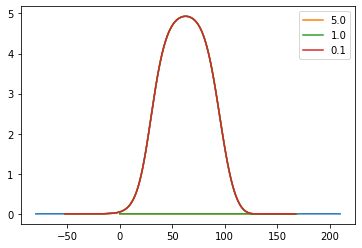

In [127]:
p = roadrunner.plot(n_points=100)

p.plot(z_history_5[:,0], z_history_5[:,1], label="5.0")
p.plot(z_history_1[:,0], z_history_1[:,1], label="1.0")
#p.plot(z_history_05[:,0], z_history_05[:,1], label="0.5")
p.plot(z_history_01[:,0], z_history_01[:,1], label="0.1")
p.legend()
plt.show()

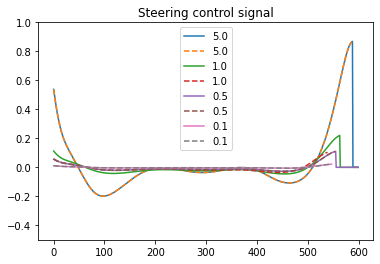

In [128]:
plt.plot(u_history_5[:,0], label="5.0")
plt.plot(u_history_5_back_cg[:,0], label="5.0", linestyle='--')
plt.plot(u_history_1[:,0], label="1.0")
plt.plot(u_history_1_back_cg[:,0], label="1.0", linestyle='--')
plt.plot(u_history_05[:,0], label="0.5")
plt.plot(u_history_05_back_cg[:,0], label="0.5", linestyle='--')
plt.plot(u_history_01[:,0], label="0.1", linestyle='-')
plt.plot(u_history_01_back_cg[:,0], label="0.1", linestyle='--')
plt.legend()
plt.ylim([-0.5,1.0])
plt.title("Steering control signal")
plt.show()

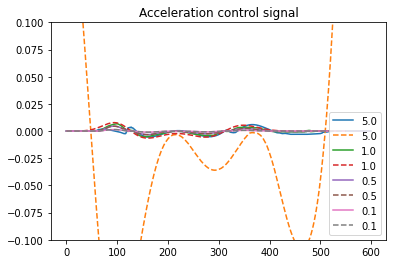

In [129]:
plt.plot(u_history_5[:,1], label="5.0")
plt.plot(u_history_5_back_cg[:,0], label="5.0", linestyle='--')
plt.plot(u_history_1[:,1], label="1.0")
plt.plot(u_history_1_back_cg[:,1], label="1.0", linestyle='--')
plt.plot(u_history_05[:,1], label="0.5")
plt.plot(u_history_05_back_cg[:,1], label="0.5", linestyle='--')
plt.plot(u_history_01[:,1], label="0.1", linestyle='-')
plt.plot(u_history_01_back_cg[:,1], label="0.1", linestyle='--')
plt.legend()
plt.title("Acceleration control signal")
plt.ylim([-0.1,0.1])
plt.show()

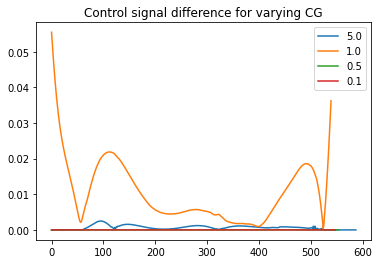

In [130]:
diff0 = np.sqrt(np.square(u_history_5[:np.size(u_history_5_back_cg)//2,0]-u_history_5_back_cg[:,0]) +
                np.square(u_history_5[:np.size(u_history_5_back_cg)//2,1]-u_history_5_back_cg[:,1]))
plt.plot(diff0, label="5.0")
diff1 = np.sqrt(np.square(u_history_1[:np.size(u_history_1_back_cg)//2,0]-u_history_1_back_cg[:,0]) +
                np.square(u_history_1[:np.size(u_history_1_back_cg)//2,1]-u_history_1_back_cg[:,1]))
plt.plot(diff1, label="1.0")
diff2 = np.sqrt(np.square(u_history_05[:np.size(u_history_05_back_cg)//2,0]-u_history_05_back_cg[:,0]) +
                np.square(u_history_05[:np.size(u_history_05_back_cg)//2,1]-u_history_05_back_cg[:,1]))
plt.plot(diff2, label="0.5")
diff3 = np.sqrt(np.square(u_history_01[:np.size(u_history_01_back_cg)//2,0]-u_history_01_back_cg[:,0]) +
                np.square(u_history_01[:np.size(u_history_01_back_cg)//2,1]-u_history_01_back_cg[:,1]))
plt.plot(diff3, label="0.1")
plt.legend()
plt.title("Control signal difference for varying CG")
plt.show()